In [1]:
import os
from torch.utils.data import Dataset
import torch
import numpy as np


class CC200Data(Dataset):
    def __init__(self, path, mapping, labels):
        super().__init__()
        self.path = path
        self.mapping = mapping
        self.folder = os.listdir(self.path)
        self.labels = self._map_labels(labels)
        self.files = [np.loadtxt(f"{path}/{i}") for i in self.folder]
        self.region_indices = self._region_mapping()
        self.region_coeff = torch.tensor([self._region_coeffs(i) for i in self.files], dtype=torch.float32)
        self.subnetwork_coeff = [self._subnetwork_coeffs(i) for i in self.files]
        self.region_start_indices = {}
        for i in range(1, 8):
            if i == 1:
                self.region_start_indices[i] = 0
            else:
                self.region_start_indices[i] = self.region_start_indices[i - 1] + len(
                    self.region_indices[i - 1]
                )

    def _map_labels(self, mapping):
        labels = []
        for i in self.folder:
            if i[:-14] in mapping.keys():
                labels.append(mapping[i[:-14]])
            else:
                print(i)

        return torch.tensor(labels, dtype=torch.long)

    def _region_coeffs(self, x):
        b = np.zeros_like(x)
        y = 0
        for i in self.region_indices:
            b[:, y : y + len(self.region_indices[i])] = x[:, self.region_indices[i]]
            y += len(self.region_indices[i])
        b = b[:, 15:]
        return np.corrcoef(b, rowvar=False)

    def _region_mapping(self):
        region_indices = {i: [] for i in range(0, 8)}
        for i, j in self.mapping.items():
            region_indices[j].append(i - 1)
        return region_indices

    def _subnetwork_coeffs(self, x):
        correlation_matrices = []

        for file_idx, (region_id, indices) in enumerate(self.region_indices.items()):
            if not indices:
                print(f"[INFO] Region {region_id} has no indices, skipping.")
                continue

            submatrix = x[:, indices]
            std = np.std(submatrix, axis=0)

            zero_std_count = np.sum(std == 0)
            if zero_std_count > 0:
                print(f"[INFO] File {self.folder[file_idx]} - Region {region_id} has {zero_std_count} constant columns.")

            try:
                correlation_matrix = np.corrcoef(submatrix, rowvar=False)
            except Exception as e:
                print(f"[ERROR] Correlation failed in region {region_id}")
                print(f"Exception: {e}")
                continue

            flat_corr = self._flatten_matrix(correlation_matrix)
            correlation_matrices.append(torch.tensor(flat_corr, dtype=torch.float32))

        return correlation_matrices

    def _flatten_matrix(self, matrix):
        idx = np.triu_indices_from(matrix, k=1)
        return matrix[idx]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        region_corr = self.region_coeff[idx]
        subnetwork_corrs = self.subnetwork_coeff[idx]
        labels = self.labels[idx]
        return region_corr, subnetwork_corrs, labels

In [2]:
# !wget https://raw.githubusercontent.com/broccubali/AutisticAdventures/main/cc200_to_yeo7_mapping.csv
# !wget https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv

In [2]:
import pandas as pd

df = pd.read_csv('cc200_to_yeo7_mapping.csv')
cc200_to_yeo7_mapping = dict(zip(df['CC200_Region'], df['Yeo7_Network'])) 

In [3]:
df = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
df = df[["FILE_ID", "DX_GROUP"]]
labels_mapping = dict(zip(df["FILE_ID"], df["DX_GROUP"]))

In [4]:
dataset = CC200Data("Outputs/cpac/nofilt_noglobal/rois_cc200", cc200_to_yeo7_mapping, labels_mapping)

/home/shusrith/projects/torch/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/shusrith/projects/torch/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_38927/1401220553.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.region_coeff = torch.tensor([self._region_coeffs(i) for i in self.files], dtype=torch.float32)


[INFO] File NYU_0051151_rois_cc200.1D - Region 5 has 1 constant columns.
[INFO] File NYU_0051151_rois_cc200.1D - Region 5 has 1 constant columns.
[INFO] File NYU_0051052_rois_cc200.1D - Region 0 has 3 constant columns.
[INFO] File MaxMun_a_0051363_rois_cc200.1D - Region 1 has 1 constant columns.
[INFO] File Leuven_2_0050753_rois_cc200.1D - Region 3 has 1 constant columns.
[INFO] File NYU_0051151_rois_cc200.1D - Region 5 has 4 constant columns.
[INFO] File UCLA_1_0051261_rois_cc200.1D - Region 6 has 4 constant columns.
[INFO] File NYU_0051015_rois_cc200.1D - Region 7 has 1 constant columns.
[INFO] File NYU_0051151_rois_cc200.1D - Region 5 has 1 constant columns.
[INFO] File NYU_0051151_rois_cc200.1D - Region 5 has 2 constant columns.
[INFO] File NYU_0051151_rois_cc200.1D - Region 5 has 1 constant columns.
[INFO] File NYU_0051052_rois_cc200.1D - Region 0 has 1 constant columns.
[INFO] File MaxMun_a_0051363_rois_cc200.1D - Region 1 has 19 constant columns.
[INFO] File OHSU_0050167_rois_cc

In [6]:
shapes = []
a = next(iter(dataset))[1]
for i in a:
    shapes.append(i.shape[0])

In [5]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSA(nn.Module):
    def __init__(self, embd_dim, num_heads):
        super().__init__()
        self.embd_dim = embd_dim
        self.num_heads = num_heads
        self.head_size = self.embd_dim // self.num_heads
        self.q = nn.Linear(self.embd_dim, self.embd_dim)
        self.k = nn.Linear(self.embd_dim, self.embd_dim)
        self.v = nn.Linear(self.embd_dim, self.embd_dim)
        self.d = self.head_size ** 0.5
        self.mlp = nn.Linear(self.embd_dim, self.embd_dim)
        self.layer_norm = nn.LayerNorm(self.embd_dim)  
        
    def forward(self, x):
        batch_size, M, _ = x.shape
        norm = self.layer_norm(x)
        q = self.q(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / self.d
        attn_scores = attn_scores.masked_fill(torch.eye(M, device=x.device).bool(), float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, v).transpose(1, 2).reshape(batch_size, M, self.embd_dim)
        out = self.mlp(context)
        return out + x, attn_weights

In [9]:
class SubnetworkEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.mlp(x)

In [7]:
class RegionEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.region_conv = nn.Conv2d(1, 1, kernel_size=1)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )       

    def forward(self, x):
        x_conv = self.region_conv(x.unsqueeze(1)) 
        x_conv = x_conv.squeeze(1)  
        return self.mlp(x_conv)  

In [11]:
class RegionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.reg_embd = RegionEmbedder(input_dim, hidden_dim, embd_dim)
        self.mhsa_layers = nn.ModuleList([MHSA(embd_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        x_reg = self.reg_embd(x)
        x_in = x_reg
        attn_weights_all = []
        for mhsa in self.mhsa_layers:
            x_in, attn_weights = mhsa(x_in)
            attn_weights_all.append(attn_weights)
        
        return x_reg + x_in, torch.stack(attn_weights_all).permute(1, 0, 2, 3, 4)

In [12]:
class SubNetworkEncoder(nn.Module):
    def __init__(self, shapes, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.embd_dim = embd_dim
        self.mlps = [SubnetworkEmbedder(i, hidden_dim, embd_dim) for i in shapes]
        self.mhsa_layers = nn.ModuleList([MHSA(embd_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        batch_size = x[0].shape[0]
        x = torch.stack([mlp(f) for mlp, f in zip(self.mlps, x)], dim=1)
        attn_weights_all = []
        for mhsa in self.mhsa_layers:
            x, attn_weights = mhsa(x)
            attn_weights_all.append(attn_weights)

        return x, torch.stack(attn_weights_all).permute(1, 0, 2, 3, 4)

In [13]:
model = SubNetworkEncoder(shapes, 256, 128, 8, 4)
a = next(iter(train_loader))[1]
model(a)[1].shape

torch.Size([64, 4, 8, 8, 8])

In [14]:
b = next(iter(train_loader))[0]
model1 = RegionEncoder(185, 256, 128, 8, 4)
model1(b)[1].shape

torch.Size([64, 4, 8, 185, 185])

In [15]:
class StepOne(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.reg_enc = RegionEncoder(input_dim, hidden_dim, embd_dim, num_heads, num_layers)
        self.subnet_enc = SubNetworkEncoder(shapes, hidden_dim, embd_dim, num_heads, num_layers)
        self.layer_norm = nn.LayerNorm(embd_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embd_dim, hidden_dim),  
            nn.ReLU(),             
            nn.Linear(hidden_dim, embd_dim)    
        )
        self.region_start_indices = list(dataset.region_start_indices.values()) + [185]

    def subNetworkAttendRegions(self, subnet_attn_map, region_attn_map):
        region_to_subnet = torch.zeros(185, dtype=torch.long)
        for subnet_id in range(7):
            start = self.region_start_indices[subnet_id]
            end = self.region_start_indices[subnet_id + 1]
            region_to_subnet[start:end] = subnet_id  
        subnet_i = region_to_subnet.view(-1, 1).expand(185, 185) 
        subnet_j = region_to_subnet.view(1, -1).expand(185, 185)  

        mask = subnet_i != subnet_j  

        attn_multiplier = subnet_attn_map[:, :, :, subnet_i, subnet_j]  
        attn_multiplier = attn_multiplier * mask

        return region_attn_map * attn_multiplier 
    
    def sinkhorn(self, attn, n_iters=5, eps=1e-6):
        attn = attn + eps  
        for _ in range(n_iters):
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn / attn.sum(dim=-2, keepdim=True)
        return attn
    
    def forward(self, x):
        x0 = self.reg_enc(x[0])
        x1 = self.subnet_enc(x[1])
        o = torch.cat((x0[0], x1[0]), dim=1)
        o_norm = self.layer_norm(o)
        o_norm = self.mlp(o)
        o = o + o_norm
        o_reg = o[:, :186, :]
        o_sub = o[:, 186:, :]
        adj_matrix = self.subNetworkAttendRegions(x1[1], x0[1])
        adj_matrix = self.sinkhorn(adj_matrix)
        return o_reg, o_sub, adj_matrix

In [16]:
model = StepOne(185, 256, 128, 16, 4)
a = model(next(iter(train_loader)))[2]
a.shape

torch.Size([64, 4, 16, 185, 185])

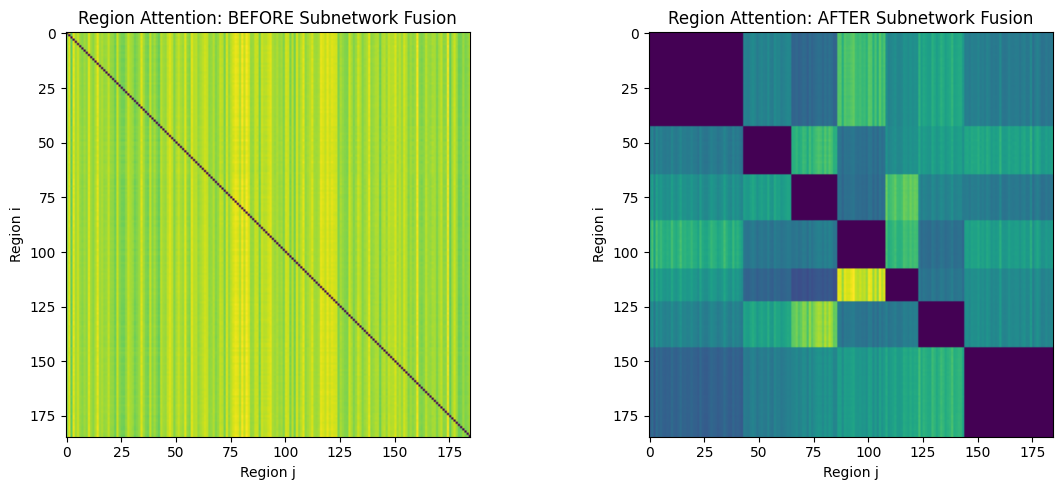

In [55]:
import matplotlib.pyplot as plt

b, l, h = 1, 0, 0  
attn_before = x[b, l, h].detach().cpu().numpy()  
attn_after = result[b, l, h].detach().cpu().numpy() 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(attn_before, cmap="viridis")
axs[0].set_title("Region Attention: BEFORE Subnetwork Fusion")
axs[0].set_xlabel("Region j")
axs[0].set_ylabel("Region i")

axs[1].imshow(attn_after, cmap="viridis")
axs[1].set_title("Region Attention: AFTER Subnetwork Fusion")
axs[1].set_xlabel("Region j")
axs[1].set_ylabel("Region i")

plt.tight_layout()
plt.show()

In [21]:
for i in range(7):
    print(a[0][0][0].sum(dim=1))
    print(a[0][0][0].sum(dim=0))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 